# COVID-19 Simulation

This COVID-19 simulation was developed by [transentis consulting](https://www.transentis.com) from Berlin, based on the [SIR model](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SIR_model).

Please read the companion blog post [Covid 19 and the SIR Model](https://www.transentis.com/covid-19-sir-model/) for details on the model and a discussion of COVID-19 scenarios.

The simulation was built using the [BPTK-Py](https://bptk.transentis-labs.com) framework, the dashboard using [Voila](https://voila.readthedocs.io/en/stable/). You can find the complete source code on [GitHub](https://github.com/transentis/sim-covid-19). 

In [1]:
name="transentis | Covid-19 simulation"
from IPython.display import display,Javascript
Javascript('document.title="{}"'.format(name))

<IPython.core.display.Javascript object>

<Figure size 1440x720 with 1 Axes>

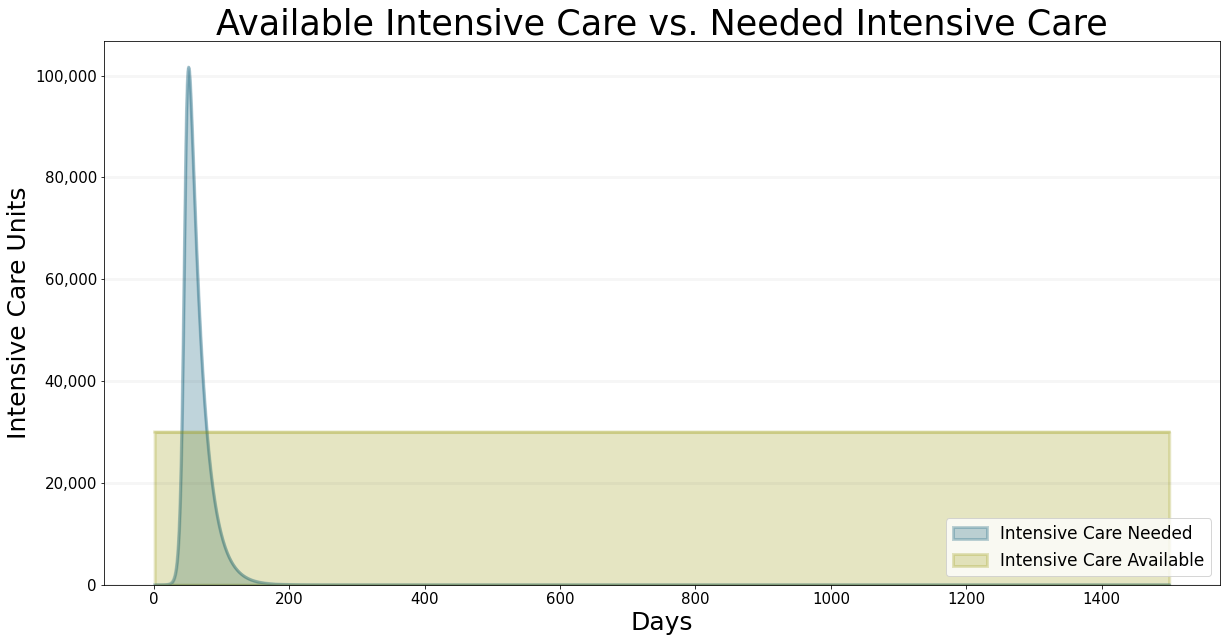

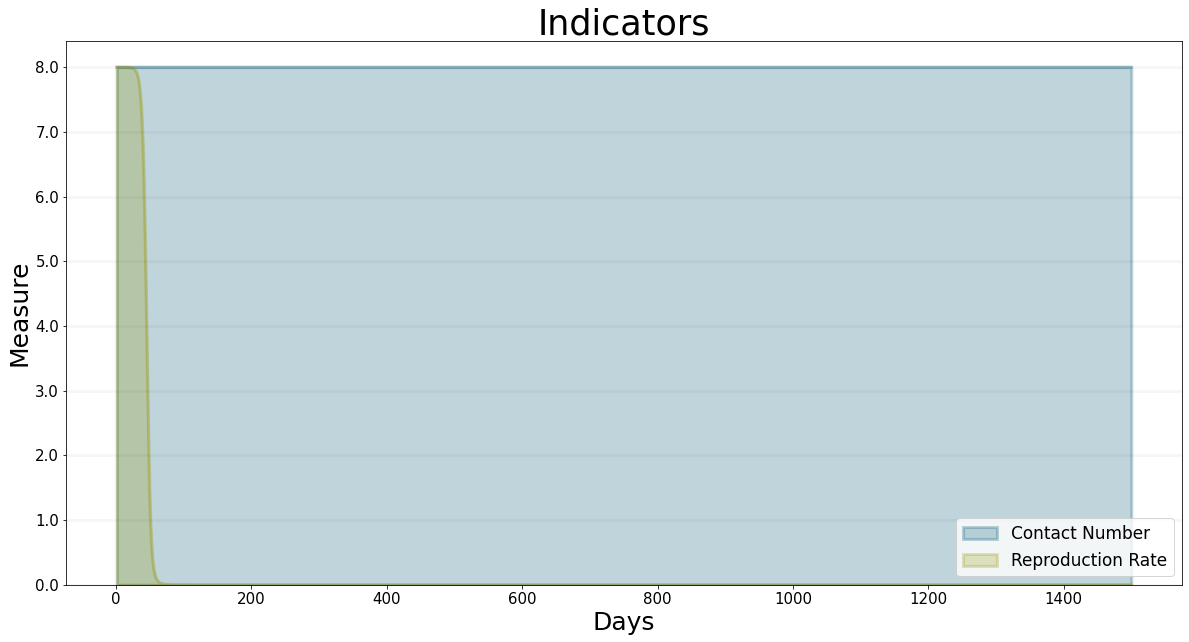

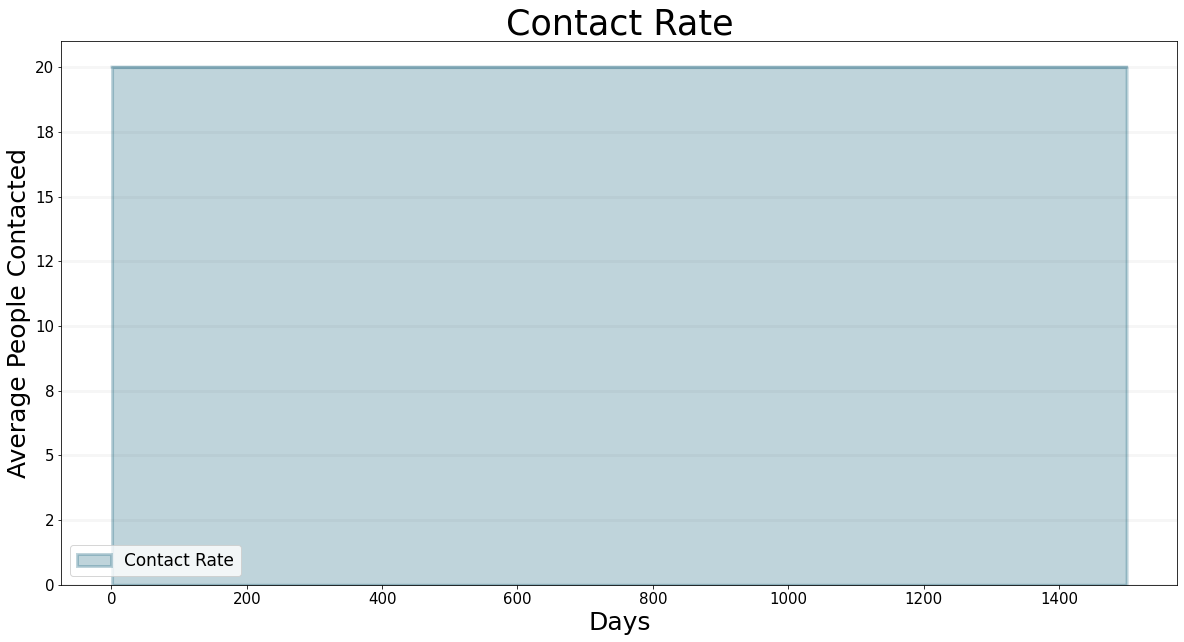

<IPython.core.display.HTML object>

In [1]:
from BPTK_Py import Model
from BPTK_Py import sd_functions as sd

model = Model(starttime=1.0,stoptime=1500.0,dt=1.0,name='sir')

susceptible = model.stock("susceptible")  # those that have not been infected yet
infectious = model.stock("infectious") # those that are currently carrying an infection
recovered = model.stock("recovered") # those that have recovered from an infection
deceased = model.stock("deceased") # those that have died from the infection

infection_rate = model.flow("infection_rate") # the rate at which people are becoming infected
recovery_rate = model.flow("recovery_rate") # the rate at which people are recovering from an infection
death_rate = model.flow("death_rate") # the rate at which people are dying from an infection

infectivity = model.constant("infectivity") # the infectivity of the corona virus
lethality = model.constant("lethality") # the lethality of the corona virus
normal_contact_rate=model.constant("normal_contact_rate") # the average contact rate between people in "normal" times
duration = model.constant("duration") # the average time it takes to recover from the virus

intensive_available = model.constant("intensive_available") # the number of intensive care units available
intensive_percentage = model.constant("intensive_percentage") # the fraction of people needing intensive care

dashboard_on=model.constant("dashboard_on") # should be equal to 1.0 for dashboard scenario and 0.0 otherwise
distancing_on=model.constant("distancing_on") # defines whether social distancing is on within an interactive scenario
distancing_contact_rate=model.constant("distancing_contact_rate") # interactive scenario: the contact rate when practicing social distancing
distancing_begin=model.constant("distancing_begin") # interactive scenario: when to begin social distancing
distancing_duration=model.constant("distancing_duration")# interactive scenario: when social distancing ends and we return to normal behavior

total_population = model.converter("total_population") # the total population, i.e the sum of susceptible, infected and recovered
contact_rate = model.converter("contact_rate") # the rate at which people are being contacted, in all scenarios

intensive_needed = model.converter("intensive_needed") # the number of intensive care units needed at any time

contact_number = model.converter("contact_number") #  measures which fraction of a susceptible population is infected by a contagious person
reproduction_rate = model.converter("reproduction_rate") # measures the rate at which an epidemic reproduces

variable_contact_rate=model.converter("variable_contact_rate") # the variable contact rate used in the detailed scenarios
dashboard_with_distancing_contact_rate=model.converter("dashboard_with_distancing_contact_rate") # the contact rate used in interactive scenarios with distancing on
dashboard_contact_rate=model.converter("dashboard_contact_rate") # the contact rate used in interactive scenarios with distancing off

susceptible.initial_value = 80000000.0
infectious.initial_value = 120.0
recovered.initial_value = 0.0
deceased.initial_value = 0.0

infectivity.equation = 0.02
duration.equation = 20.0
lethality.equation = 0.001

intensive_percentage.equation = 0.002
intensive_available.equation = 30000.0
intensive_needed.equation =infectious*intensive_percentage

susceptible.equation = -infection_rate
infectious.equation = infection_rate - recovery_rate - death_rate
recovered.equation = recovery_rate
deceased.equation = death_rate

total_population.equation = susceptible+infectious+recovered

infection_rate.equation = (contact_rate*infectivity*infectious)*(susceptible/total_population)

recovery_rate.equation = infectious/duration

death_rate.equation = infectious*lethality

contact_number.equation=contact_rate*infectivity*duration
reproduction_rate.equation=contact_number*(susceptible/total_population)

contact_rate.equation=20

contact_rate.equation=dashboard_on*dashboard_contact_rate+(-dashboard_on+1.0)*variable_contact_rate
dashboard_on.equation=1.0
distancing_on.equation=0.0
dashboard_contact_rate.equation=distancing_on*dashboard_with_distancing_contact_rate+(-distancing_on+1.0)*normal_contact_rate
dashboard_with_distancing_contact_rate.equation=sd.If(sd.Or(sd.time()<distancing_begin,sd.time()>distancing_begin+distancing_duration),normal_contact_rate,distancing_contact_rate)
normal_contact_rate.equation=20.0
distancing_contact_rate.equation=2.0
distancing_begin.equation=20.0
distancing_duration.equation=200.0

variable_contact_rate.equation=sd.lookup(sd.time(),"variable_contact_rate")

variable_contact_rate_points = [[0,20.0],[1500,20.0]]

model.points["variable_contact_rate"]=variable_contact_rate_points

import BPTK_Py
import pandas as pd
bptk = BPTK_Py.bptk()
bptk.register_model(model)

bptk.register_scenarios(
    scenarios ={
        "base": {},
        "weakSocialDistancing": {},
        "strongSocialDistancing": {},
        "shortTermMeasures": {},
        "dashboard":{}
    },
    scenario_manager="smSir")

bptk.reset_simulation_model(scenario_manager="smSir", scenario="dashboard")

%matplotlib inline
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets
from IPython.display import HTML
out_population = widgets.Output()
out_intensive_care = widgets.Output()
out_indicators = widgets.Output()
out_contact_rate = widgets.Output()
out_assumptions = widgets.Output()

wdg_style_distancing_on = {'description_width': 'initial'}
wdg_distancing_on = widgets.Checkbox(
        value=False,
        continuous_update=False,
        disabled=False,
        description='Introduce Social Distancing',
        style=wdg_style_distancing_on
    )
wdg_distancing_on.layout.width='450px'

wdg_style_normal_contact_rate = {'description_width': 'initial'}
wdg_normal_contact_rate=widgets.FloatSlider(
        value=20,
        min=0,
        max=40,
        step=1,
        continuous_update=False,
        description='Normal Contact Rate',
        style=wdg_style_normal_contact_rate
    )
wdg_normal_contact_rate.layout.width='450px'

wdg_style_vis_begin= {'description_width': 'initial'}
wdg_vis_begin=widgets.IntSlider(
        value=0,
        min=0,
        max=1499,
        continuous_update=False,
        description='Visualization Period Begin',
        style=wdg_style_vis_begin
    )
wdg_vis_begin.layout.width='450px'

wdg_style_vis_end = {'description_width': 'initial'}
wdg_vis_end=widgets.IntSlider(
        value=1500,
        min=1,
        max=1500,
        continuous_update=False,
        description='Visualization Period End',
        style=wdg_style_vis_end
    )
wdg_vis_end.layout.width='450px'

wdg_style_distancing_contact_rate = {'description_width': 'initial'}
wdg_distancing_contact_rate=widgets.FloatSlider(
        value=2,
        min=0,
        max=20,
        step=1,
        continuous_update=False,
        description='Distancing Contact Rate',
        style=wdg_style_distancing_contact_rate
    )
wdg_distancing_contact_rate.layout.width='450px'


wdg_style_distancing_begin= {'description_width': 'initial'}
wdg_distancing_begin=widgets.FloatSlider(
        value=20,
        min=0,
        max=200,
        step=1,
        continuous_update=False,
        description='Distancing Begin',
        style=wdg_style_distancing_begin
    )
wdg_distancing_begin.layout.width='450px'

wdg_style_distancing_duration= {'description_width': 'initial'}
wdg_distancing_duration=widgets.FloatSlider(
        value=100,
        min=0,
        max=1300,
        step=1,
        continuous_update=False,
        description='Distancing Duration',
        style=wdg_style_distancing_duration
    )
wdg_distancing_duration.layout.width='450px'

def event_handler_distancing_on(change):
    update_graphs(change.new, wdg_normal_contact_rate.value, wdg_vis_begin.value, wdg_vis_end.value, wdg_distancing_contact_rate.value, wdg_distancing_begin.value, wdg_distancing_duration.value)
    
def event_handler_normal_contact_rate(change):
    update_graphs(wdg_distancing_on.value, change.new, wdg_vis_begin.value, wdg_vis_end.value, wdg_distancing_contact_rate.value, wdg_distancing_begin.value,wdg_distancing_duration.value)
    
def event_handler_vis_begin(change):
    update_graphs(wdg_distancing_on.value, wdg_normal_contact_rate.value,change.new, wdg_vis_end.value, wdg_distancing_contact_rate.value, wdg_distancing_begin.value,wdg_distancing_duration.value)
    
def event_handler_vis_end(change):
    update_graphs(wdg_distancing_on.value, wdg_normal_contact_rate.value, wdg_vis_begin.value, change.new, wdg_distancing_contact_rate.value, wdg_distancing_begin.value,wdg_distancing_duration.value)
     
def event_handler_distancing_contact_rate(change):
    update_graphs(wdg_distancing_on.value, wdg_normal_contact_rate.value, wdg_vis_begin.value, wdg_vis_end.value, change.new, wdg_distancing_begin.value, wdg_distancing_duration.value)
    
def event_handler_distancing_begin(change):
    update_graphs(wdg_distancing_on.value, wdg_normal_contact_rate.value, wdg_vis_begin.value, wdg_vis_end.value, wdg_distancing_contact_rate.value,change.new,wdg_distancing_duration.value)
    
def event_handler_distancing_duration(change):
    update_graphs(wdg_distancing_on.value, wdg_normal_contact_rate.value, wdg_vis_begin.value, wdg_vis_end.value, wdg_distancing_contact_rate.value,wdg_distancing_begin.value,change.new)
   
    
def update_graphs(distancing_on, normal_contact_rate, vis_begin, vis_end, distancing_contact_rate,distancing_begin, distancing_duration):
    scenario= bptk.get_scenario("smSir","dashboard")

    scenario.constants["distancing_on"]=1.0 if distancing_on else 0.0
    scenario.constants["normal_contact_rate"]=normal_contact_rate
    scenario.constants["distancing_contact_rate"]=distancing_contact_rate
    scenario.constants["distancing_begin"]=distancing_begin
    scenario.constants["distancing_duration"]=distancing_duration
    scenario.constants["dashboard_on"]=1.0
    
    wdg_distancing_contact_rate.layout.visibility = 'visible' if distancing_on else 'hidden'
    wdg_distancing_begin.layout.visibility = 'visible' if distancing_on else 'hidden'
    wdg_distancing_duration.layout.visibility = 'visible' if distancing_on else 'hidden'
    
    bptk.reset_simulation_model(scenario_manager="smSir", scenario="dashboard")

    out_population.clear_output(wait=True)
    out_intensive_care.clear_output(wait=True)
    out_contact_rate.clear_output(wait=True)
    out_assumptions.clear_output(wait=True)
    out_indicators.clear_output(wait=True)
    
    with out_population:
        # turn of pyplot's interactive mode to ensure the plot is not created directly
        plt.ioff()
        # clear the widgets output ... otherwise we will end up with a long list of plots, one for each change of settings
        
        # create the plot, but don't show it yet
        plot=bptk.plot_scenarios(
            scenario_managers=["smSir"],
            scenarios=["dashboard"],
            title="Recovered Population vs. Deaths",
            x_label="Days",
            y_label="Persons",
            equations=[
                "infectious",
                "recovered",
                "deceased"
            ],
             series_names={
                 "smSir_dashboard_infectious":"Infectious Population",
                 "smSir_dashboard_recovered":"Recovered Population",
                 "smSir_dashboard_deceased":"Deceased"     
            },
            visualize_from_period=vis_begin,
            visualize_to_period=vis_end
        )
        # show the plot
        plt.show(plot)
        # turn interactive mode on again
        plt.ion()  
              
    with out_intensive_care:
        plt.ioff()
        plot=bptk.plot_scenarios(
            scenario_managers=["smSir"],
            scenarios=["dashboard"],
            title="Available Intensive Care vs. Needed Intensive Care",
            x_label="Days",
            y_label="Intensive Care Units",
            equations=[
                "intensive_needed",
                "intensive_available"
            ],
            series_names={
                "smSir_dashboard_intensive_needed": "Intensive Care Needed",
                "smSir_dashboard_intensive_available": "Intensive Care Available"  
            },
            visualize_from_period=vis_begin,
            visualize_to_period=vis_end        
        )
        plt.show(plot)
        plt.ion()
        
    with out_indicators:
        plt.ioff()
        plot=bptk.plot_scenarios(
            scenario_managers=["smSir"],
            scenarios=["dashboard"],
            title="Indicators",
            x_label="Days",
            y_label="Measure",
            equations=[
                "contact_number",
                "reproduction_rate"
            ],
            series_names={
                "smSir_dashboard_contact_number": "Contact Number",
                "smSir_dashboard_reproduction_rate": "Reproduction Rate" 
            },
            visualize_from_period=vis_begin,
            visualize_to_period=vis_end
        )
        plt.show(plot)
        plt.ion()
    with out_contact_rate:
        plt.ioff()
        plot=bptk.plot_scenarios(
            scenario_managers=["smSir"],
            scenarios=["dashboard"],
            title="Contact Rate",
            x_label="Days",
            y_label="Average People Contacted",
            equations=[
                "contact_rate"
            ],
            series_names={
                "smSir_dashboard_contact_rate": "Contact Rate" 
            },
            visualize_from_period=vis_begin,
            visualize_to_period=vis_end
        )
        plt.show(plot)
        plt.ion()
    with out_assumptions:
        display(HTML("<p>The implementation here is roughly calibrated to the current situation in Germany (as of 27.3.2020). It illustrates the effects of social distancing in achieving the objective of keeping the strain on the health care system as small as possible.</p><ul><li>Contact Rate: 20 persons. Defines how many people a person encounters per day in average.</li><li>Infectivity: 2%. Defines the probability that a person becomes infected after contact with an infectious person.</li><li>Duration. Defines how long an infective person remains contagious</li><li>Population. The susceptible population starts at 80 Mio., the infectious population starts at 120 persons.</li><li>Intensive Care Needed: 0.2%. Measures the number of infected people who need intensive care.</li><li>Intensive Care Available: 30,000 units. The number of intensive care units available.</li></ul><p>With the above settings, this means we have a <i>contact number</i> of 8 in the base settings. The contact number is the product of contact rate, infectivity and duration.</p>"))
        
              

wdg_distancing_on.observe(event_handler_distancing_on, names="value")
wdg_normal_contact_rate.observe(event_handler_normal_contact_rate, names="value")
wdg_vis_begin.observe(event_handler_vis_begin, names="value")
wdg_vis_end.observe(event_handler_vis_end, names="value")
wdg_distancing_contact_rate.observe(event_handler_distancing_contact_rate, names="value")
wdg_distancing_begin.observe(event_handler_distancing_begin, names="value")
wdg_distancing_duration.observe(event_handler_distancing_duration, names="value")

tabbed_graphs = widgets.Tab(children = [out_population, out_intensive_care, out_indicators, out_contact_rate, out_assumptions])
tabbed_graphs.set_title(0, 'Population')
tabbed_graphs.set_title(1, 'Intensive Care')
tabbed_graphs.set_title(2, 'Indicators')
tabbed_graphs.set_title(3, 'Contact Rate')
tabbed_graphs.set_title(4, 'Assumptions')

display(tabbed_graphs)


control_panel = widgets.GridBox([
    wdg_vis_begin,wdg_vis_end,
    wdg_distancing_on,
    wdg_normal_contact_rate,
    wdg_distancing_contact_rate,
    wdg_distancing_begin,
    wdg_distancing_duration],
    layout=widgets.Layout(grid_template_columns="repeat(2, 500px)"))
display(control_panel)


update_graphs(wdg_distancing_on.value,
              wdg_normal_contact_rate.value,
              wdg_vis_begin.value,
              wdg_vis_end.value,
              wdg_distancing_contact_rate.value,
              wdg_distancing_begin.value,
              wdg_distancing_duration.value)